# QAOA Runtime

The Qiskit runtime is an execution model that permits us to run an entire program on the backend side. Here, we discuss how to run the QAOA algorithm in the Qiskit runtime. We will discuss several of the features that this first version of the QAOA Runtime makes available.



In [1]:
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")

## Preliminaries

First, we load the program and inspect its arguments to know what inputs it is expecting. We also investigate the return types to understand what will be returned to us. We obtain the QAOA program from the provider as follows.

In [2]:
program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

The arguments to the runtime are obtained as follows.

In [3]:
print(f"Program name: {qaoa_program.name}, Program id: {qaoa_program.program_id}")
print(qaoa_program.parameters())

Program name: qaoa, Program id: qaoa
ParameterNamespace (Values):
| Name       | Value        | Type         | Required |     Description |
-------------------------------------------------------------------------
| reps       | None         | integer     | False    | The number of QAOA repetitions, i.e. the QAOA depth typically labeled p. This value defaults to 1. This is an integer. |
| alpha      | None         | number      | False    | The fraction of top measurement samples to be used for the expectation value (CVaR expectation). Defaults to 1, i.e. using all samples to construct the expectation value. |
| operator   | None         | object      | True     | The cost Hamiltonian, consisting of Pauli I and Z operators, whose smallest eigenvalue we're trying to find. The type must be a PauliSumOp. |
| optimizer  | None         | object      | False    | The classical optimizer used to update the parameters in each iteration. Per default, SPSA with automatic calibration of the learn

Here, we see the different input arguments which we now elaborate on.

* **operator** is by far the most important argument since it represent the cost operator that we want to minimize. For QAOA this corresponds to a `PauliSumOp`. Each time there is a quadratic term between two decision variables in the problem we wish to minimize there will be a corresponding `ZZ` term in the `PauliSumOp`. For example, the operator `PauliSumOp.from_list([("ZIZ", 1), ("IZZ", -1), ("ZZI", 1)])` may correspond to a Maxcut problem on a triangle where one edge has a negative weight.
* **optimizer** represents the optimizer used in the closed-loop classical optimization. This will default to SPSA to deal with the noise of the hardware.
* **reps** this integer is the number of QAOA layers.
* **initial_point** is the initial values for $\gamma$ and $\beta$. This is a list given in the following order $[\gamma_1, \beta_1, \gamma_2, \beta_2, ...]$. The length of this list should therefore be twice the QAOA depth (i.e. the `reps` parameter).
* **shots** is the number of shots to gather for each circuit.
* **alpha** is the $\alpha$ of the CVaR optimization [1]. If $\alpha$ is smaller than one then only the best $\alpha$ fraction of shots will be retained in the optimization, i.e. this corresponds to using `CVaRExpectation(alpha, PauliExpectation())` which can be found in `qiskit.opflow`.
* **measurement_error_mitigation** determines or not to use readout error mitigation. If `True`, the algorithm used this will employ the `TensoredMeasFitter`. 
* If **use_swap_strategies** is `True` the QAOA program will transpile the QAOA circuit with dedicated swap strategies that take into account the commutative nature of the `ZZ` operators in QAOA and the coupling map of the backend on which the program will run. If this option is False then the QAOA program will default to the standard transpiler with optimization level 1. This optimization level can be chosen using the **optimization_level** input option.
* If **use_pulse_efficient** is set to `True` then a pulse efficient transpilation will be run at each QAOA iteration [2]. This collects two-qubit blocks and applies Cartan's KAK decomposition to obtain a `RZXGate` representation of the circuit. Scaled cross-resonance pulses are then used. Further details are given in Appendix A below.
* If **use_initial_mapping** is `True` then a heuristic algorithm will be run to permute the Pauli operators in the cost operator to better fit the coupling map of the device. This permutation is only applied if the `use_swap_strategies` option is set to `True` and only makes sense for non-fully-connected problems.
* **optimization_level** This is the optimization level of the Qiskit transpiler if swap strategies are not used. The default value is 1.

### References

[1] P. Kl. Barkoutsos, G. Nannicini, A. Robert, I. Tavernelli, and S. Woerner, *Improving Variational Quantum Optimization using CVaR*, Quantum **4**, 256 (2020).

[2] N. Earnest, C. Tornow, and D. J. Egger, *Pulse-efficient circuit transpilation for quantum applications on cross-resonance-based hardware*, Phys. Rev. Research **3**, 043088 (2021).

## Running the QAOA runtime program

We now show how to use the QAOA runtime program with a five qubit example. 

Here, we show how to directly call the program on the cloud. However, Qiskit Optimization provides the `QAOAClient` which seamlessly fits in the Qiskit Optimization workflow and can be used as a direct replacement of your local `QAOA` algorithm. This `QAOAClient` is discussed below in this tutorial.

In [4]:
import numpy as np

from qiskit.tools import job_monitor
from qiskit.opflow import PauliSumOp, Z, I
from qiskit.algorithms.optimizers import SPSA

# Define the cost operator to run.
op = (
    (Z ^ Z ^ I ^ I ^ I)
    - (I ^ I ^ Z ^ Z ^ I)
    + (I ^ I ^ Z ^ I ^ Z)
    - (Z ^ I ^ Z ^ I ^ I)
    - (I ^ Z ^ Z ^ I ^ I)
    + (I ^ Z ^ I ^ Z ^ I)
    + (I ^ I ^ I ^ Z ^ Z)
)

# SPSA helps deal with noisy environments.
optimizer = SPSA(maxiter=100)

# We will run a depth two QAOA.
reps = 2

# The initial point for the optimization, chosen at random.
initial_point = np.random.random(2 * reps)

# The backend that will run the programm.
options = {"backend_name": "ibmq_qasm_simulator"}

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
    # Set to True when optimizing sparse problems.
    "use_initial_mapping": False,
    # Set to true when using echoed-cross-resonance hardware.
    "use_pulse_efficient": False,
}

Now, we run the program using the provider.

In [5]:
job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

In [6]:
job_monitor(job)

Job Status: job has successfully run


In [7]:
print(f"Job id: {job.job_id()}")
print(f"Bob status: {job.status()}")

Job id: c9h9ear00uf4rq9vqhq0
Bob status: JobStatus.DONE


Once the job has successfully executed we can retrieve the result from the job. The result object contains information on the optimization. For self consistency it also contains the inputs to the QAOA program that are accessible through `result["inputs"]`. The value under `"inputs"` is a dictionary with the keys described above.

In [8]:
result = job.result()

Of particular interest is the energy that was measured on the hardware at each iteration as well as the returned eigenstate. For this example we assume that the energy of the cost operator that we minimized corresponds to an instance of a MaxCut problem.

In [9]:
from collections import defaultdict


def op_adj_mat(op: PauliSumOp) -> np.array:
    """Extract the adjacency matrix from the op."""
    adj_mat = np.zeros((op.num_qubits, op.num_qubits))
    for pauli, coeff in op.primitive.to_list():
        idx = tuple([i for i, c in enumerate(pauli[::-1]) if c == "Z"])  # index of Z
        adj_mat[idx[0], idx[1]], adj_mat[idx[1], idx[0]] = np.real(coeff), np.real(coeff)

    return adj_mat


def get_cost(bit_str: str, adj_mat: np.array) -> float:
    """Return the cut value of the bit string."""
    n, x = len(bit_str), [int(bit) for bit in bit_str[::-1]]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost += adj_mat[i, j] * x[i] * (1 - x[j])

    return cost


def get_cut_distribution(result) -> dict:
    """Extract the cut distribution from the result.

    Returns:
        A dict of cut value: probability.
    """

    adj_mat = op_adj_mat(PauliSumOp.from_list(result["inputs"]["operator"]))

    state_results = []
    for bit_str, amp in result["eigenstate"].items():
        state_results.append((bit_str, get_cost(bit_str, adj_mat), amp**2 * 100))

    vals = defaultdict(int)

    for res in state_results:
        vals[res[1]] += res[2]

    return dict(vals)

Text(0, 0.5, 'Probability')

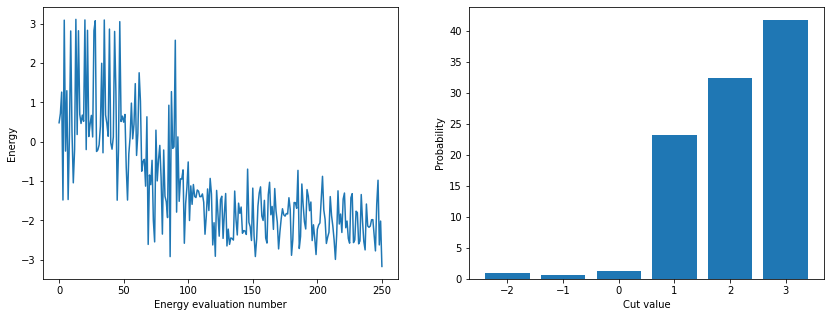

In [10]:
import matplotlib.pyplot as plt

cut_vals = get_cut_distribution(result)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(result["optimizer_history"]["energy"])
axs[1].bar(list(cut_vals.keys()), list(cut_vals.values()))
axs[0].set_xlabel("Energy evaluation number")
axs[0].set_ylabel("Energy")
axs[1].set_xlabel("Cut value")
axs[1].set_ylabel("Probability")

## Qiskit optimization

The functionality discussed above is implemented in Qiskit-optimization where the QAOA-runtime is accessible through the `runtime` module. We now show how to use this module with the `QAOAClient`.

In [11]:
from qiskit_optimization.runtime import QAOAClient
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram

In [12]:
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2})
print(qubo.prettyprint())

Problem name: 

Minimize
  x y - x z + 2 y z + x - 2 y + 3 z

Subject to
  No constraints

  Binary variables (3)
    x y z



In [13]:
qaoa_mes = QAOAClient(
    provider=provider, backend=provider.get_backend("ibmq_qasm_simulator"), reps=2, alpha=0.75
)

qaoa = MinimumEigenOptimizer(qaoa_mes)

In [14]:
result = qaoa.solve(qubo)
print(result)

optimal function value: -2
optimal value: x=0, y=1, z=0
status: SUCCESS


## Appendix A: Pulse-efficient transpilation

The QAOA runtime program can leverage a pulse-efficient transpilation which minimizes the number of single-qubit pulses and makes use of the cross-resonance scaling methodology applicable to the echoed-cross-resonance gates of IBM Quantum Systems. For completeness we here show the pass manager that is implemented.

In [15]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary as std_eqlib,
)
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnrollCustomDefinitions,
    BasisTranslator,
    Optimize1qGatesDecomposition,
)
from qiskit.transpiler.passes.calibration.builders import RZXCalibrationBuilderNoEcho
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import (
    EchoRZXWeylDecomposition,
)

from qiskit.test.mock import FakeBelem

In [16]:
backend = FakeBelem()

The pulse efficient pass is implemented using transpiler passes from qiskit. It requires knowledge of the pulse-enabled backend to attached scaled cross-resonance gates to the `RZXGate`s obtained from the KAK decomposition. These scaled gates are based on the schedules of the calibrated CNOT gates.

In [17]:
rzx_basis = ["rzx", "rz", "x", "sx"]

pulse_efficient = PassManager(
    [
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=["rz", "sx", "x", "rxx"]),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        # Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis),
    ]
)

To demonstrate the pass we construct an arbitrary circuit with blocks of two-qubit gates.

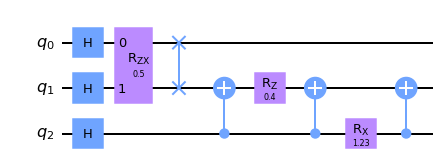

In [18]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(3)
circ.h([0, 1, 2])
circ.rzx(0.5, 0, 1)
circ.swap(0, 1)
circ.cx(2, 1)
circ.rz(0.4, 1)
circ.cx(2, 1)
circ.rx(1.23, 2)
circ.cx(2, 1)
circ.draw("mpl")

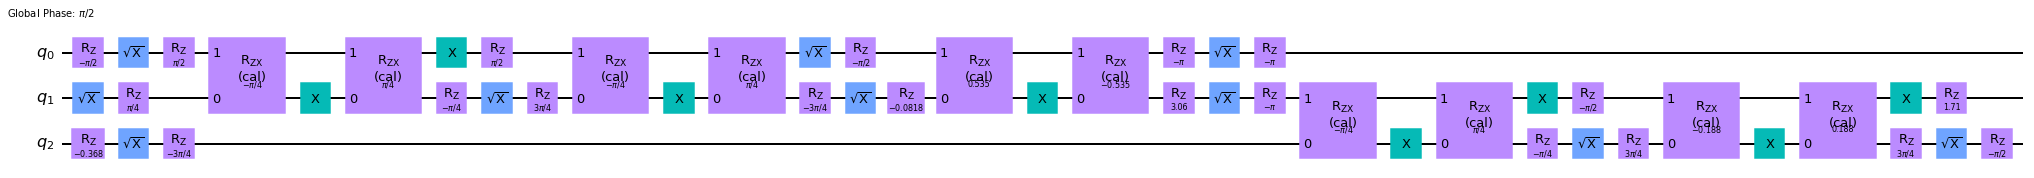

In [19]:
pulse_efficient.run(circ).draw("mpl", fold=False)

In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright